In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

In [8]:
res_1_df = pd.read_csv('results_1.1.csv')

In [ ]:
os.makedirs('plots', exist_ok=True)

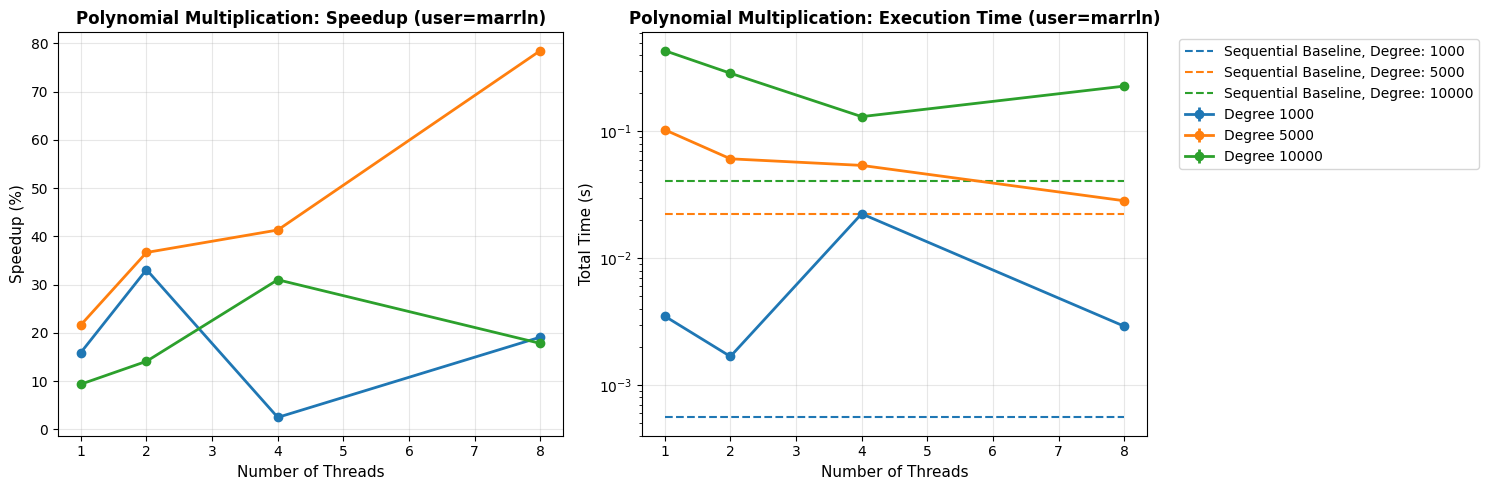

In [ ]:
# Aggregate by user, degree and threads: compute mean and std for time_total
res_1_df['threads_num'] = pd.to_numeric(res_1_df['threads'], errors='coerce')
# Ensure a user column exists
if 'user' not in res_1_df.columns:
    res_1_df['user'] = 'marrln'

grouped = res_1_df.groupby(['user', 'degree', 'threads'], as_index=False).agg(
    time_total_mean=('time_total', 'mean'),
    time_total_std=('time_total', 'std')
)

# Helper to get sequential baseline mean per user+degree
seq_baselines = grouped[grouped['threads'] == 'sequential'].set_index(['user', 'degree'])['time_total_mean']

users = sorted(res_1_df['user'].unique())

for user in users:
    user_group = grouped[grouped['user'] == user]
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Speedup plot with error bars (propagated from parallel std)
    for degree in sorted(user_group['degree'].unique()):
        deg_grp = user_group[user_group['degree'] == degree]
        if ('sequential' not in list(deg_grp['threads'])):
            # try to get from original data if missing
            seq_time = res_1_df[(res_1_df['user'] == user) & (res_1_df['degree'] == degree) & (res_1_df['threads'] == 'sequential')]['time_total'].mean()
        else:
            seq_time = seq_baselines.loc[(user, degree)]
        par = deg_grp[deg_grp['threads'] != 'sequential'].copy()
        par['threads_num'] = pd.to_numeric(par['threads'], errors='coerce')
        par = par.dropna(subset=['threads_num']).sort_values('threads_num')
        if par.empty:
            continue
        # speedup = seq_mean / mean_parallel; propagate std roughly: ds = (seq / mean^2) * std_parallel
        speedup = seq_time / par['time_total_mean']
        speedup_std = (seq_time / (par['time_total_mean'] ** 2)) * par['time_total_std']
        axes[0].errorbar(par['threads_num'], 100.0 * speedup, yerr=100.0 * speedup_std, marker='o', linewidth=2, markersize=6, label=f'Degree {degree}')

    axes[0].set_xlabel('Number of Threads', fontsize=11)
    axes[0].set_ylabel('Speedup (%)', fontsize=11)
    axes[0].set_title(f'Polynomial Multiplication: Speedup (user={user})', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Total execution time with error bars
    for degree in sorted(user_group['degree'].unique()):
        deg_grp = user_group[user_group['degree'] == degree]
        par = deg_grp[deg_grp['threads'] != 'sequential'].copy()
        par['threads_num'] = pd.to_numeric(par['threads'], errors='coerce')
        par = par.dropna(subset=['threads_num']).sort_values('threads_num')
        if par.empty:
            continue
        line = axes[1].errorbar(par['threads_num'], par['time_total_mean'], yerr=par['time_total_std'], marker='o', linewidth=2, markersize=6, label=f'Degree {degree}')
        # add horizontal sequential baseline
        if (user, degree) in seq_baselines.index:
            seq_time = seq_baselines.loc[(user, degree)]
            color = line[0].get_color() if hasattr(line[0], 'get_color') else None
            xmin = par['threads_num'].min()
            xmax = par['threads_num'].max()
            axes[1].hlines(seq_time, xmin=xmin, xmax=xmax, colors=color, linestyles='--', linewidth=1.5)
            axes[1].plot([], [], color=color, linestyle='--', linewidth=1.5, label=f"Sequential Baseline, Degree: {degree}")

    axes[1].set_xlabel('Number of Threads', fontsize=11)
    axes[1].set_ylabel('Total Time (s)', fontsize=11)
    axes[1].set_yscale('log')
    axes[1].set_title(f'Polynomial Multiplication: Execution Time (user={user})', fontsize=12, fontweight='bold')
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    outname = f'results_1_1_graph_{user}.png'
    plt.savefig(outname)
    plt.show()

# If multiple users exist, produce a combined figure showing all users
if len(users) > 1:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    for user in users:
        user_group = grouped[grouped['user'] == user]
        for degree in sorted(user_group['degree'].unique()):
            deg_grp = user_group[user_group['degree'] == degree]
            par = deg_grp[deg_grp['threads'] != 'sequential'].copy()
            par['threads_num'] = pd.to_numeric(par['threads'], errors='coerce')
            par = par.dropna(subset=['threads_num']).sort_values('threads_num')
            if par.empty:
                continue
            axes[0].errorbar(par['threads_num'], 100.0 * (seq_baselines.loc[(user, degree)] / par['time_total_mean']), yerr=100.0 * ((seq_baselines.loc[(user, degree)] / (par['time_total_mean'] ** 2)) * par['time_total_std']), marker='o', linewidth=1.5, markersize=5, label=f'{user} deg={degree}')
            axes[1].errorbar(par['threads_num'], par['time_total_mean'], yerr=par['time_total_std'], marker='o', linewidth=1.5, markersize=5, label=f'{user} deg={degree}')
    axes[0].set_xlabel('Number of Threads')
    axes[0].set_ylabel('Speedup (%)')
    axes[0].grid(True, alpha=0.3)
    axes[1].set_xlabel('Number of Threads')
    axes[1].set_ylabel('Total Time (s)')
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('results_1_1_graph_all_users.png')
    plt.show()